# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                            mean_absolute_error)
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    return np.sin(w) * np.cos(w) * 2

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

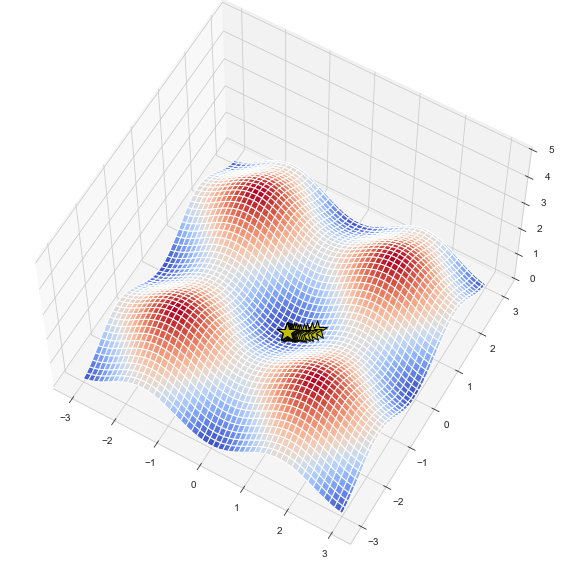

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

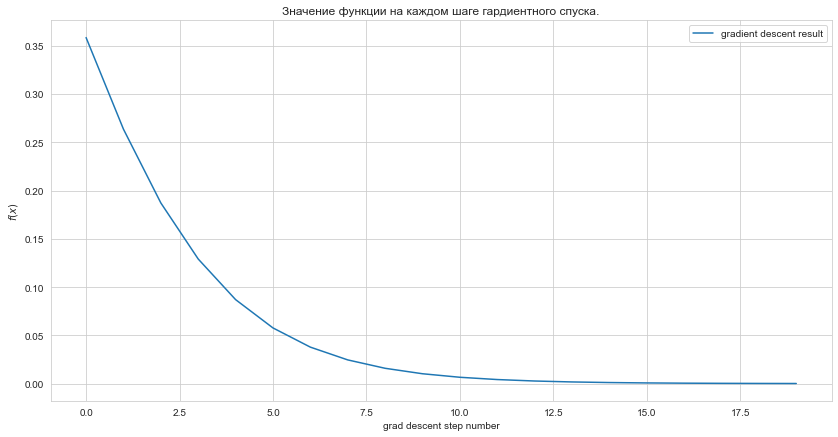

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.mean((np.square(y_true - y_pred)))


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return (X.T @ (y_pred - y_true)) * (2 / y_true.shape[0])


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return X_test @ self.W
            
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

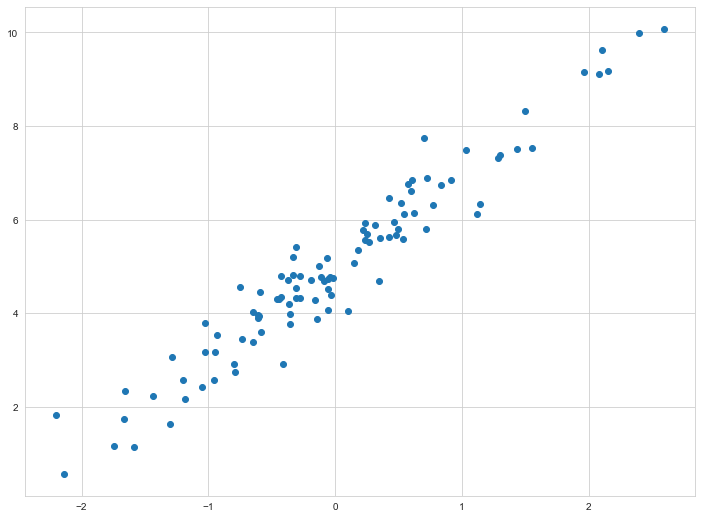

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

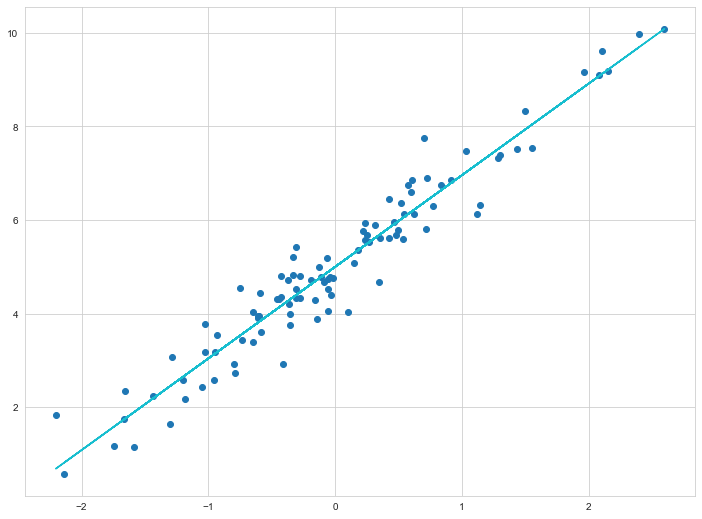

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X), color="tab:cyan", alpha=1);

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [20]:
X = pd.DataFrame(X, columns=feature_names)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [21]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Небольшое описание колонок датасета:
* MedInc медианный доход группы участков
* HouseAge медианный возраст дома для блока группы
* AveRooms среднее количество комнат на домохозяйство
* AveBedrms среднее количество спален на домохозяйство
* Population население блок группы
* AveOccup среднее количество членов домохозяйства
* Latitude широта
* Longitude долгота

Целевая переменная (он же y) - медианная стоимость дома для районов Калифорнии ($100 000)

In [22]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


Все переменные - числа, так что нет необходимости что-либо переводить.
Теперь посмотрим на описательные статистики, чтобы понять стоит ли стандартизировать данные.

In [23]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


Стандартизация необходима (средние сильно отличаются). Теперь посмотрим на NA значения:

In [24]:
X.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

Отлично, у нас нет NA. Также отберем предикторы, посмотрев на их корреляцию между собой и уберем по одному из пар сильно коррелирующих (либо отрицательно, либо положительно).

In [25]:
X.corr()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,1.000000,-0.119034,0.326895,-0.062040,0.004834,0.018766,-0.079809,-0.015176
HouseAge,-0.119034,1.000000,-0.153277,-0.077747,-0.296244,0.013191,0.011173,-0.108197
AveRooms,0.326895,-0.153277,1.000000,0.847621,-0.072213,-0.004852,0.106389,-0.027540
AveBedrms,-0.062040,-0.077747,0.847621,1.000000,-0.066197,-0.006181,0.069721,0.013344
Population,0.004834,-0.296244,-0.072213,-0.066197,1.000000,0.069863,-0.108785,0.099773
AveOccup,0.018766,0.013191,-0.004852,-0.006181,0.069863,1.000000,0.002366,0.002476
Latitude,-0.079809,0.011173,0.106389,0.069721,-0.108785,0.002366,1.000000,-0.924664
Longitude,-0.015176,-0.108197,-0.027540,0.013344,0.099773,0.002476,-0.924664,1.000000


Заметна сильная отрицательная взаимосвязь (-0.924664) между переменными Latitude и Longitudе, веротяно из-за географии штата, откуда взяты данные. Также существует сильная положительная (0.847621) - между AveRooms и AveBedrmsсредним - что логично, количество комнат и спален в доме взаимосвязаны.
Уберем Longitude и AveBedrms:

In [26]:
X = X.drop(['Longitude', 'AveBedrms'], axis=1)

Стандартизуем данные, используем sci-kit learn Standard scaler (! Не забудем перед этим поделить данные на train, test):

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

In [28]:
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_test)

Посмотрим основные метрики:

In [30]:
print(f'R-squared: {round(r2_score(y_test, y_pred), 3)}')
print(f'MSE: {round(mean_squared_error(y_test, y_pred), 3)}')
print(f'MAE: {round(mean_absolute_error(y_test, y_pred), 3)}')

R-squared: 0.503
MSE: 0.665
MAE: 0.602


Посмотрим на список самых важных признаков (предикторов) модели:

In [31]:
np.argsort(abs(linear_regression.coef_))[::-1]

array([0, 1, 5, 4, 2, 3], dtype=int64)

И посмотрим на первые 4:

In [32]:
feature_names[0], feature_names[1], feature_names[5], feature_names[4]

('MedInc', 'HouseAge', 'AveOccup', 'Population')

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [33]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [34]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / n
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return X.T @ (y_pred - y_true) 


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [35]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return sigmoid(X_test @ self.W)
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [36]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

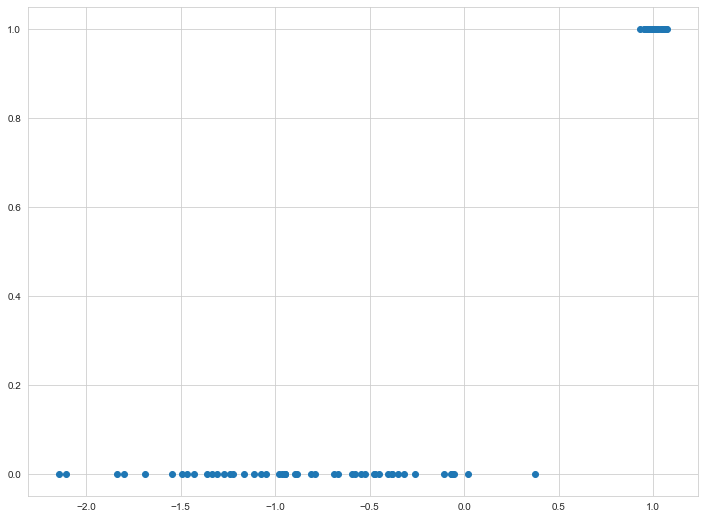

In [37]:
plt.scatter(X, y);

In [38]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

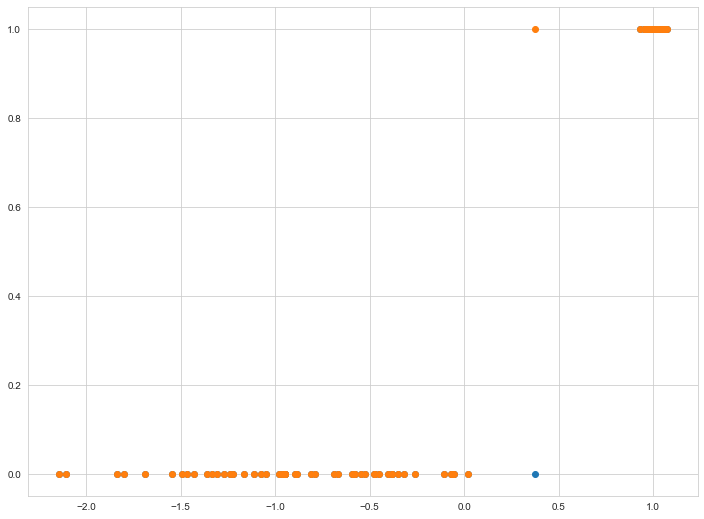

In [39]:
y_pred = np.where(y_pred >= 0.5, 1, 0) 

plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [41]:
print('Precision: %.3f' % precision_score(y, y_pred)) 
print('Recall: %.3f' % recall_score(y, y_pred)) 
print('F1 Score: %.3f' % f1_score(y, y_pred)) 
print('Accuracy: %.3f' % accuracy_score(y, y_pred)) 

Precision: 0.980
Recall: 1.000
F1 Score: 0.990
Accuracy: 0.990


#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [42]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

Посмотрим на датасет:
 * #: ID для каждого покемона
 * Name: Название каждого покемона
 * Type 1: определяет слабость и способность защиты от атак
 * Type 2: двойной тип
 * Total: сумма всех статистик
 * HP: здоровь
 * Attack: базовый модификатор обычных атак
 * Defense: базовое сопротивление урону от обычных атак
 * Sp.Atk: специальная атака, базовый модификатор для специальных атак
 * Sp.Def: базовое сопротивление урону от специальных атак
 * Speed: определяет, какой покемон атакует первым

In [43]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


Переведем Legendary в число

In [44]:
pokemon.Legendary = pokemon.Legendary.astype(int)

In [45]:
pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,0
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,0


Теперь посмотрим на колонки, какие из них можно убрать?
* Первый вариант: колонка # - она уникальная для кажого вида, но внутри вида для конкретных особей одинакова (как пример - Venusaur и VenusaurMega Venusaur), так что уберем
* Второй вариант: колонка Name - проверим колонку на уникальность имен, и в случае положительного ответа уберем
* Третий вариант: колонка Total - просто сумма нескольких (HP, Attack, Defense, Sp. Atk, Sp. Def, Speed) колонок, так что тоже убираем

In [46]:
pokemon[["Name"]].value_counts().unique()

array([1], dtype=int64)

In [47]:
pokemon = pokemon.drop(["#", "Name", "Total"], axis=1)

Посмотрим на Тип1 и Тип2. У всех есть Тип1, но не у всех есть Тип2. Я оставлю эти колонки, так что заменим NA нa None.

In [48]:
pokemon.isna().sum()

Type 1          0
Type 2        386
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

In [49]:
pokemon['Type 2'].fillna(value='None', inplace=True)

Generation категориальный признак, как и Тип1, Тип2. Также будет необходжима стандартизация:

In [50]:
pokemon["Generation"].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [51]:
pokemon.describe()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000,800.00000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375,0.08125
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129,0.27339
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000,0.00000
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000,0.00000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000,0.00000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000,0.00000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000,1.00000


И у нас есть сильный дисбаланс классов (делать мы с этим, конечно же, ничего не будем).

Попробуем реализовать пайплайн (попытка номер два).

In [52]:
cat_cols = ["Type 1", "Type 2", "Generation"]
num_cols = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
all_features = cat_cols + num_cols

target = pokemon["Legendary"].values

X = pokemon[all_features]
y = target

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(), cat_cols)
])

In [54]:
preprocessor.transformers

[('scaler',
  StandardScaler(),
  ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']),
 ('ohe', OneHotEncoder(), ['Type 1', 'Type 2', 'Generation'])]

Разделите ваши данные на тестовую и тренировочную выборку.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.1)

Обучите модель `LogisticRegression` из `sklearn`.

In [56]:
log_regression_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("log_regression_pipeline", LogisticRegression(class_weight="balanced"))
])
log_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['HP', 'Attack', 'Defense',
                                                   'Sp. Atk', 'Sp. Def',
                                                   'Speed']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Type 1', 'Type 2',
                                                   'Generation'])])),
                ('log_regression_pipeline',
                 LogisticRegression(class_weight='balanced'))])

In [57]:
y_pred = log_regression_pipeline.predict(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

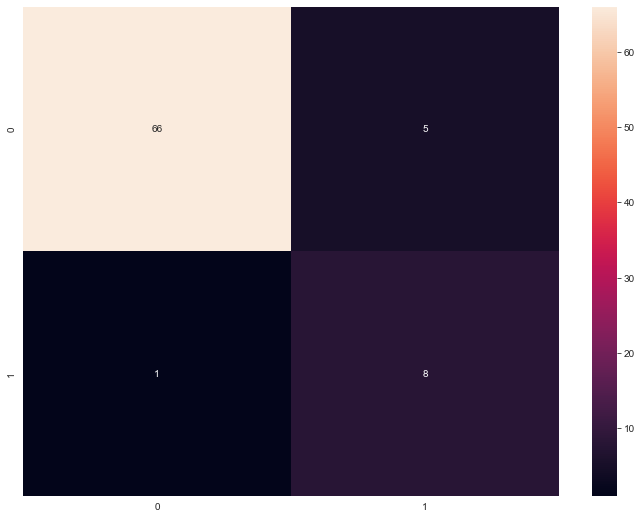

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class_names = ['0', '1']
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=class_names, index = class_names)
sns.heatmap(cm, annot=True, fmt='d');

ROC AUC=0.97


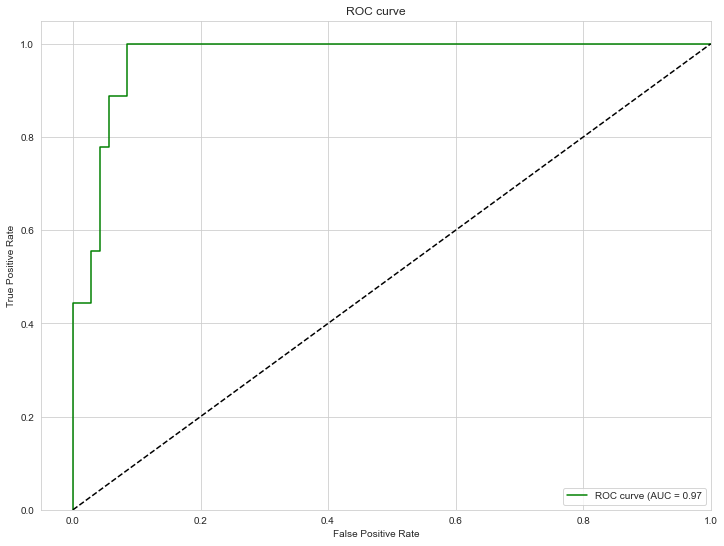

In [59]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn import metrics

lr_probs = log_regression_pipeline.predict_proba(X_test)


lr_probs = lr_probs[:, 1] #  вероятности только положительного исхода


lr_auc = roc_auc_score(y_test, lr_probs) # ROC AUC
print(f'ROC AUC={round(lr_auc, 2)}')


fpr, tpr, treshold = metrics.roc_curve(y_test, lr_probs) # roc-кривa
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, color='green',
         label=f'ROC curve (AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

In [60]:
feature_names = log_regression_pipeline[:-1].get_feature_names_out()
feature_names

array(['scaler__HP', 'scaler__Attack', 'scaler__Defense',
       'scaler__Sp. Atk', 'scaler__Sp. Def', 'scaler__Speed',
       'ohe__Type 1_Bug', 'ohe__Type 1_Dark', 'ohe__Type 1_Dragon',
       'ohe__Type 1_Electric', 'ohe__Type 1_Fairy',
       'ohe__Type 1_Fighting', 'ohe__Type 1_Fire', 'ohe__Type 1_Flying',
       'ohe__Type 1_Ghost', 'ohe__Type 1_Grass', 'ohe__Type 1_Ground',
       'ohe__Type 1_Ice', 'ohe__Type 1_Normal', 'ohe__Type 1_Poison',
       'ohe__Type 1_Psychic', 'ohe__Type 1_Rock', 'ohe__Type 1_Steel',
       'ohe__Type 1_Water', 'ohe__Type 2_Bug', 'ohe__Type 2_Dark',
       'ohe__Type 2_Dragon', 'ohe__Type 2_Electric', 'ohe__Type 2_Fairy',
       'ohe__Type 2_Fighting', 'ohe__Type 2_Fire', 'ohe__Type 2_Flying',
       'ohe__Type 2_Ghost', 'ohe__Type 2_Grass', 'ohe__Type 2_Ground',
       'ohe__Type 2_Ice', 'ohe__Type 2_None', 'ohe__Type 2_Normal',
       'ohe__Type 2_Poison', 'ohe__Type 2_Psychic', 'ohe__Type 2_Rock',
       'ohe__Type 2_Steel', 'ohe__Type 2_Water', '

In [61]:
feature_coef = abs(log_regression_pipeline.steps[1][1].coef_[0])
feature_coef

array([1.22551318, 0.89653188, 1.57374264, 1.67627153, 1.65547662,
       1.84080292, 0.94624915, 0.25986809, 0.68585847, 0.11630413,
       0.43022526, 0.4500593 , 0.65711499, 0.76080481, 0.24546566,
       0.01876303, 0.48703045, 0.57124848, 1.49106381, 0.0380164 ,
       0.96507891, 0.98551802, 0.61251202, 0.39476167, 0.0048519 ,
       0.87830155, 0.93742474, 0.09571495, 0.18817144, 0.40619934,
       0.02330947, 1.54507751, 0.31008991, 0.09501045, 1.0890084 ,
       0.00702166, 0.97754047, 0.07134063, 0.65161554, 0.11717082,
       0.04006538, 0.07752301, 0.56543098, 1.29429936, 0.15439525,
       0.08095694, 0.10117062, 0.89823356, 0.36853224])

In [62]:
df = pd.DataFrame({"feature_names": feature_names, "coef": feature_coef})
df.sort_values(by = ["coef"], ascending = False).head(5)

,feature_names,coef
5,scaler__Speed,1.840803
3,scaler__Sp. Atk,1.676272
4,scaler__Sp. Def,1.655477
2,scaler__Defense,1.573743
31,ohe__Type 2_Flying,1.545078


Самый весомый вклад у скорости, специальных атак и зациты от специальных атак противника. Помимо защиты также важность имеет способность летать.

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

На самом деле я сейчас больше меломан, не могу так сразу назвать группу, которая мне нравится больше всего. 
Пожалуй это будет Panic! At The Disco. С ними я познакомилась впервые на песне с названием House of Memories, потому что увидела эдит по сериалу, который смотрела под нее. Песня великолепна (сериал тоже), мне нравится плавное акцентирование на приперве и небольшая кульминация сразу после. Да и текст хорош, потому что когда послушаешь песню больше трех раз начинаеш не просто мелодию слышать, а еще и текст осознавать, по крайней мере у меня именно так.
Вторая моя любимая песня этой группы High Hopes. У нее совершенно другое настроения, она такая немножко крейзи, но олновременно с этим есть какая то торжественность. В общем, совсем другое настроение, но они обе прекрасны!


## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

Это домашнее задание действительно было проще первого, как минимум потому, что большая часть кода заботливо написана))
Было интересно (и сложно) разбираться в уже написанном коде, тем не менее задание не было слишком простым. Надеюсь анализ датасета у меня был проведен верно, по крайней мере насколько я знаю порядок должен быть примерно такой.
Очень милый датасет по покемонам, я не ценительнь, но знаток)))